## Tutorial - Sampling sparse logistic regression

Author: Shidi Zhao (zhao5@fb.com)

The purpose of this tutorial is to demonstrate how to generate data to train a sparse logistic regression model in Bean Machine and present some inference methods that Bean Machine provides to sample this model, and showcase of how to use german-numeric data to train the sparse logistic regression model.

## Problem

Logistic Regression is a very commonly used statistical method that allows us to predict a binary output from a set of independent variables. Suppose we have some prior knowledge about the data generated from the logistic regression model, we can sample the logistic regression model from the prior. The sparse logistic regression is a type of logistic regression model, it embeds feature selection in the classification by adding overall and pre-dimension scale factors, and has many applications in high-dimensional data, such as classifying credit score. So here, to sample the sparse logistic regression in Bean Machine, we first implement the sparse logistic regression model in Bean Machine and then try to sample it with various inference methods.

## Sparse logistic regression

Sparse logistic regression is a hierarchical logistic regression with a sparse prior $\tau$. We consider the model as following:

   $$
\begin{array}{lcl}
\tau {\sim} Gamma(\alpha = 0.5, \beta = 0.5) \\
\lambda_d{\sim} Gamma(\alpha = 0.5, \beta = 0.5) \\
\beta_d{\sim} Normal(0,1) \\
y_n{\sim}Bernoulli(\sigma({X}^T(\tau\beta \circ \lambda))) \\
\end{array}
$$

Here $\tau$ is the global shrinkage, $\lambda$ is local shrinkage,$\beta \circ \lambda$ denotes the elementwise product of $\beta$ and $\lambda$.

## Prerequisites

Please import the following code packages for the rest of the code in the tutorial to work.

In [40]:
import torch
import numpy as np
import beanmachine.ppl as bm
from torch.distributions import *
from beanmachine.ppl.diagnostics.diagnostics import BaseDiagnostics
from beanmachine.ppl.inference.abstract_infer import (
    VerboseLevel,
)
from torch import tensor,manual_seed, arange, float32, zeros, ones, randn
import matplotlib.pyplot as plt
import pandas as pd

## Data generation 

To get the prior knowledge about the model, we can generate some data (x,y) use a pre-defined sparse logistic regression model with generated $\tau$-value, $\lambda$-value, and $\beta$-value. Then we divide the generated data into training(50%) and test data(50%) and give the training data for inference and measure log_prob of test data.

In [41]:
manual_seed(40)

D=3 #number of predictors
N=100 #number of observations

tau_value = Gamma(tensor(0.5),tensor(0.5)).sample()
lambda_value = Gamma(0.5,0.5).sample(sample_shape=(D,1))
beta_value = Normal(0,1).sample(sample_shape=(D,1))
X = Normal(0,10).sample(sample_shape=(N,D)) 
mu = X.mm(torch.mul(tau_value*beta_value,lambda_value))
Y= Bernoulli(logits=mu).sample()

In [42]:
train_size=test_size= int(N/2)

TRAIN_DATA_X = X[:train_size]
TEST_DATA_X = X[test_size:]
TRAIN_DATA_Y = Y[:train_size]
TEST_DATA_Y = Y[test_size:]

## Model

To implement sparse logistic regression model in Bean Machine, we have random variable $\tau$(), $\lambda$(), $\beta$() and y(). Here, we sample the random variables using MCMC, the observation here is the training data. Then we compute the predictive log-likelihood using test data. The predictive log-likelihood has an important role in statistical model comparison, the highest predictive log-likelihood will have the highest posterior probability, thus it can measure how the model fits overall.

In [44]:
class Sparse(object):
    def __init__(self,num_predictors,train_x,test_x,test_y):
        self.D = num_predictors
        self.TRAIN_DATA_X = train_x
        self.TEST_DATA_X=test_x
        self.TEST_DATA_Y=test_y
        
    @bm.random_variable
    def tau(self):
        return Gamma(tensor(0.5), tensor(0.5))

    @bm.random_variable
    def lambda_(self):
        return Gamma(tensor([[0.5]] * (self.D)), tensor([[0.5]] * (self.D)))

    @bm.random_variable
    def beta(self):
        return Normal(zeros((self.D, 1)), ones((self.D, 1)))

    @bm.random_variable
    def y(self):
        y_=self.TRAIN_DATA_X.mm(torch.mul(self.tau()*self.beta(),self.lambda_()))
        return Bernoulli(logits=y_)

    @bm.functional
    def log_prob_test(self):
        y = self.TEST_DATA_X.mm(torch.mul(self.tau()*self.beta(),self.lambda_()))
        s =(Bernoulli(logits=y)).log_prob(self.TEST_DATA_Y).sum()
        return s

## Inference

Now, we will go through the performance of different inference methods on this model. We will investigate different inference algorithms, single-site Hamiltonian Monte Carlo (HMC), single-site MetropolisHastings, and single-site Newtonian Monte Carlo (NMC)

### Single-site NMC

In [45]:
s = Sparse(D,TRAIN_DATA_X,TEST_DATA_X,TEST_DATA_Y)
dict_y = {s.y(): TRAIN_DATA_Y}
nw = bm.SingleSiteNewtonianMonteCarlo()
samples_nw = nw.infer([s.log_prob_test(),s.tau(),s.lambda_(),s.beta()], dict_y , 1000, 3,verbose=VerboseLevel.OFF)

In [46]:
post_nw = tensor(samples_nw[s.log_prob_test()])
p_nw=post_nw.cumsum(dim=0) / arange(1, len(post_nw[0])+1)

## Visualizations

Visualize the posterior of the latent variables, and the growth of the cumulative average log-likelihood of test data.

In [115]:
def plots(sample,random_variable,true_value,sample_size):
    
    #posterior of random variable
    plt.figure(figsize=(10,8))
    plt.hist([sample[random_variable][0, i, 0].item() for i in range(sample_size)], bins=20)
    if true_value:
        plt.axvline(x=round(true_value.mean().item(), 3), c='k', linewidth=5) 

Posterior of $\lambda$ 

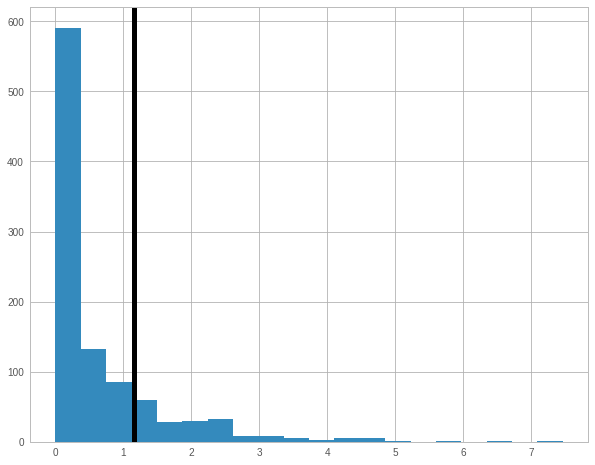

In [50]:
plots(samples_nw,s.lambda_(),lambda_value,1000)

Posterior of $\beta$ 

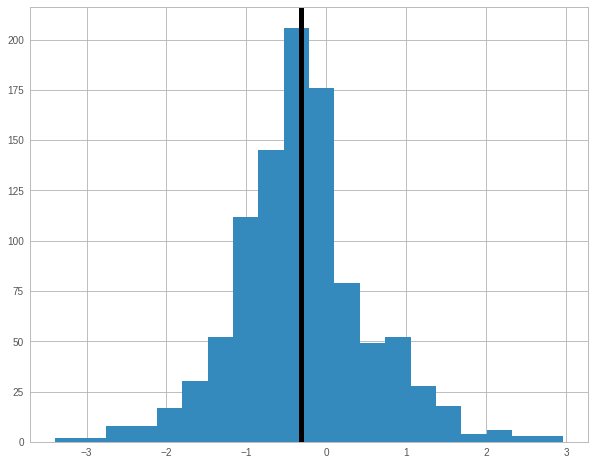

In [51]:
plots(samples_nw,s.beta(),beta_value,1000)

## Analysis¶

Here, we compare the mean value of tao, lambda and beat with the generated $\tau$-value, $\lambda$-value, and $\beta$-value, and compute the effective sample size and r hat of the samples as well.

In [56]:
def analysis(label,samples, model_tao,model_lambda,model_beta,D,tau_value,lambda_value,beta_value):
    
    Tau = samples[model_tao].detach()
    Lambda = samples[model_lambda].detach()
    Beta=samples[model_beta].detach()
    
    if tau_value:
        print("for "+label+":")
        data = [[round(samples[model_tao].mean().item(), D),round(tau_value.mean().item(), D)],[round(samples[model_lambda].mean().item(), D),round(lambda_value.mean().item(), D)],[round(samples[model_beta].mean().item(), D),round(beta_value.mean().item(), D)]]
        df = pd.DataFrame(data,columns=['Predicted value','True value'],index=['Tao','Lambda','Beta'])
        print(df)
    else:
        print("for "+label+":")
        data = [[round(samples[model_tao].mean().item(), D)],[round(samples[model_lambda].mean().item(), D)],[round(samples[model_beta].mean().item(), D)]]
        df = pd.DataFrame(data,columns=['Predicted value'],index=['Tao','Lambda','Beta'])
        print(df)
    
    print("for "+label+":")
    data = [[round(bm.effective_sample_size(Tau).mean().item(),D),round(bm.split_r_hat(Tau).mean().item(),D)],[round(bm.effective_sample_size(Lambda).mean().item(),D),round(bm.split_r_hat(Lambda).mean().item(),D)],[round(bm.effective_sample_size(Beta).mean().item(),D),round(bm.split_r_hat(Beta).mean().item(),D)]]
    df = pd.DataFrame(data,columns=['effective_sample_size','r_hat'],index=['Tao','Lambda','Beta'])
    print(df)     

In [57]:
analysis("Single-site NMC",samples_nw,s.tau(),s.lambda_(),s.beta(),D,tau_value,lambda_value,beta_value)

for Single-site NMC:
        Predicted value  True value
Tao               0.124       0.001
Lambda            0.659       1.155
Beta             -0.206      -0.314
for Single-site NMC:
        effective_sample_size  r_hat
Tao                   282.737  1.012
Lambda                729.189  1.002
Beta                 1610.244  1.002


From the analysis, we can see the lambda would get stuck with half-space proposer in NMC. Since it is in half-space, so it initializes the value with 1. We can see from the mean value of $\lambda$, it does not move. And we try with the current real space proposer, the acceptance is 5% for 100 samples. We would continue working on this model with the latest NMC inference method.

### Single-site MetropolisHastings

In [58]:
s = Sparse(D,TRAIN_DATA_X,TEST_DATA_X,TEST_DATA_Y)
mh = bm.SingleSiteAncestralMetropolisHastings()
samples_mh = mh.infer([s.log_prob_test(),s.tau(),s.lambda_(),s.beta()], dict_y, 1000, 3,verbose=VerboseLevel.OFF)

In [59]:
post_mh = tensor(samples_mh[s.log_prob_test()])
p_mh=post_mh.cumsum(dim=0) / arange(1, len(post_mh[0])+1)

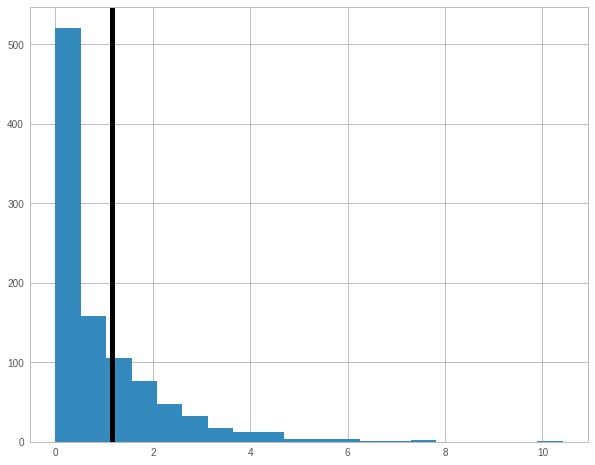

In [60]:
plots(samples_mh,s.lambda_(),lambda_value,1000)

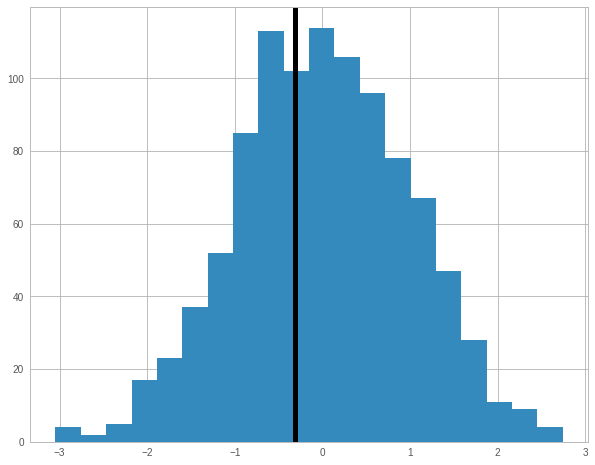

In [61]:
plots(samples_mh,s.beta(),beta_value,1000)

In [62]:
analysis("Single-site MH",samples_mh,s.tau(),s.lambda_(),s.beta(),D,tau_value,lambda_value,beta_value)

for Single-site MH:
        Predicted value  True value
Tao               0.956       0.001
Lambda            0.988       1.155
Beta              0.003      -0.314
for Single-site MH:
        effective_sample_size  r_hat
Tao                  2241.793  1.003
Lambda               2832.573  1.000
Beta                 2918.648  1.000


### Single-site HMC

In [63]:
s = Sparse(D,TRAIN_DATA_X,TEST_DATA_X,TEST_DATA_Y)
step_size = 0.5
num_steps=1
hmc = bm.SingleSiteHamiltonianMonteCarlo(step_size, num_steps)
samples_hmc = hmc.infer([s.log_prob_test(),s.tau(),s.lambda_(),s.beta()], dict_y , 1000, 3,verbose=VerboseLevel.OFF)

In [64]:
post_hmc = tensor(samples_hmc[s.log_prob_test()])
p_hmc=post_hmc.cumsum(dim=0) / arange(1, len(post_hmc[0])+1)

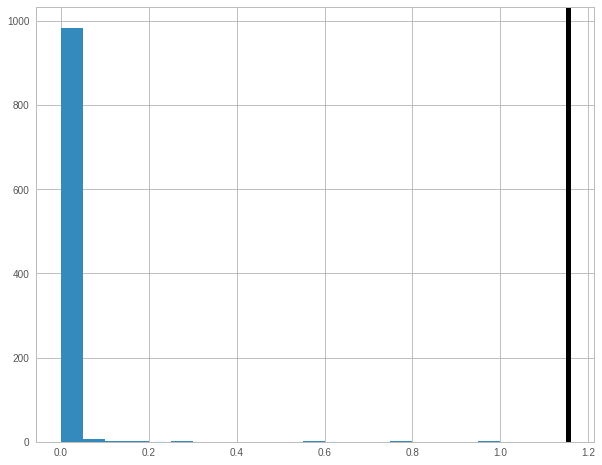

In [65]:
plots(samples_hmc,s.lambda_(),lambda_value,1000)

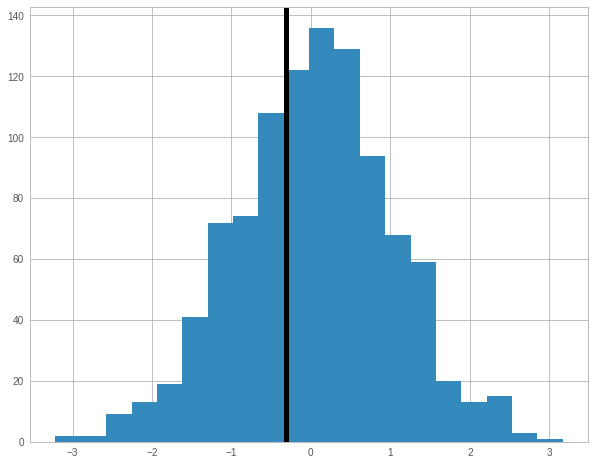

In [66]:
plots(samples_hmc,s.beta(),beta_value,1000)

In [67]:
analysis("Single-site HMC",samples_hmc,s.tau(),s.lambda_(),s.beta(),D,tau_value,lambda_value,beta_value)

for Single-site HMC:
        Predicted value  True value
Tao               0.011       0.001
Lambda            0.005       1.155
Beta             -0.017      -0.314
for Single-site HMC:
        effective_sample_size  r_hat
Tao                    91.508  1.021
Lambda                187.690  1.010
Beta                 1000.064  1.002


in HMC inference, lambda has a hard time to move.

## Log_prob analysis

In [68]:
y = TEST_DATA_X.mm(torch.mul(tau_value*beta_value,lambda_value))
s =(Bernoulli(logits=y)).log_prob(TEST_DATA_Y).sum()
print("true log_prob value of test data:",s)

true log_prob value of test data: tensor(-34.6161)


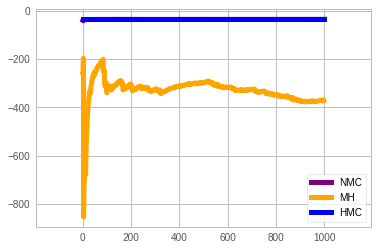

In [106]:
p_nw = post_nw.cumsum(dim=1)/ arange(1, len(post_mh[0])+1)
p_mh = post_mh.cumsum(dim=1)/ arange(1, len(post_mh[0])+1)
p_hmc = post_hmc.cumsum(dim=1)/ arange(1, len(post_mh[0])+1)

x = np.linspace(0, 1000, 100)
fig, ax = plt.subplots()
ax.plot(p_nw[-1],color="purple",linewidth=5,label='NMC')
ax.plot(p_mh[-1],color="orange",linewidth=5,label='MH')
ax.plot(p_hmc[-1],color="blue",linewidth=5,label='HMC')
ax.axis('equal')
leg = ax.legend()

In [141]:
def analysis_log(p_nw,p_mh,p_hmc,true_value,sample_size):
    if true_value:
        data = [[round(p_nw[-1].mean().item(), sample_size),true_value],[round(p_mh[-1].mean().item(), sample_size),true_value],[round(p_hmc[-1].mean().item(), sample_size),true_value]]
        df = pd.DataFrame(data,columns=['Predicted value','True value'],index=['NMC','MH','HMC'])
        print(df)
    else:
        data = [[round(p_nw[-1].mean().item(), sample_size)],[round(p_mh[-1].mean().item(), sample_size)],[round(p_hmc[-1].mean().item(), sample_size)]]
        df = pd.DataFrame(data,columns=['Predicted value'],index=['NMC','MH','HMC'])
        print(df)

In [96]:
analysis_log(p_nw,p_mh,p_hmc,s.item(),1000)

     Predicted value  True value
NMC       -35.263012  -34.616058
MH       -329.300000  -34.616058
HMC       -34.657000  -34.616058


## German-numeric data

Next, we consider our sparse logistic regression model with German credit dataset, you can download the data from: https://archive.ics.uci.edu/ml/machine-learning-databases/statlog/german/german.data-numeric. 
We use the numeric variant of the german credit dataset, with the covariates standardized to range between -1 and 1. With the addition of a constant factor, this yields 25 covariates (the data preprocess is the same as [NeuTra](https://arxiv.org/pdf/1903.03704.pdf) paper.

In [107]:
data = np.genfromtxt("german.data-numeric")
x = data[:, :-1]
y = (data[:, -1] - 1)
x_min = np.min(x, 0, keepdims=True)
x_max = np.max(x, 0, keepdims=True)
x /= (x_max - x_min)
x = 2.0 * x - 1.0
x = np.concatenate([x, np.ones([x.shape[0], 1])], -1)
x =[torch.from_numpy(x[i]) for i in range(1000)]
y = torch.from_numpy(y).view(len(x),1)
D,N=len(x[0]),len(x)

Since we only want to use all the data to train the model, we do not have test data as the previous case. here in the input, test data is the same as training data, which is the whole data set. And we use log_prob_test() to compute the predictive log-likelihood of training data.

In [108]:
train_size=test_size= int(N/2)
TRAIN_DATA_X = torch.stack(x[:train_size]).float()
TEST_DATA_X = torch.stack(x[test_size:]).float()
TRAIN_DATA_Y = y[:train_size]
TEST_DATA_Y=y[test_size:]

In [109]:
s = Sparse(D,TRAIN_DATA_X,TEST_DATA_X,TEST_DATA_Y)

In [110]:
dict_y = {s.y(): TRAIN_DATA_Y}

s = Sparse(D,TRAIN_DATA_X,TEST_DATA_X,TEST_DATA_Y)
nw = bm.SingleSiteNewtonianMonteCarlo()
samples_nw_g = nw.infer([s.tau(),s.lambda_(),s.beta(),s.log_prob_test()], dict_y , 1000, 3,verbose=VerboseLevel.OFF)

In [111]:
post_nw_g = tensor(samples_nw_g[s.log_prob_test()])
p_nw_g=post_nw_g.cumsum(dim=0) / arange(1, len(post_nw_g[0])+1)

In [113]:
analysis("single-site NMC on german data",samples_nw_g, s.tau(),s.lambda_(),s.beta(),D,None,None,None)

for single-site NMC on german data:
        Predicted value
Tao            1.040194
Lambda         0.991486
Beta          -0.005697
for single-site NMC on german data:
        effective_sample_size     r_hat
Tao               3110.137939  1.000821
Lambda            2916.411133  0.999839
Beta              2228.690674  1.000347


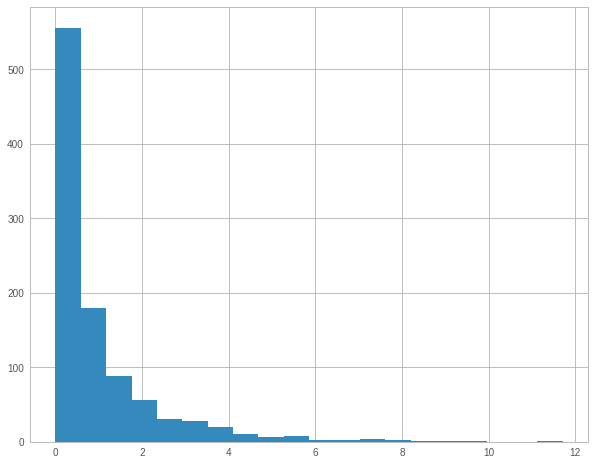

In [116]:
plots(samples_nw_g,s.lambda_(),None,1000)

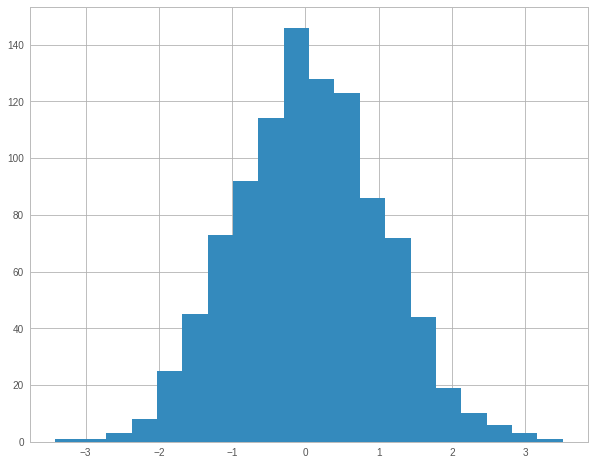

In [117]:
plots(samples_nw_g,s.beta(),None,1000)

In [118]:
dict_y = {s.y(): TRAIN_DATA_Y}

s = Sparse(D,TRAIN_DATA_X,TEST_DATA_X,TEST_DATA_Y)
mh = bm.SingleSiteAncestralMetropolisHastings()
samples_mh_g = mh.infer([s.tau(),s.lambda_(),s.beta(),s.log_prob_test()], dict_y , 1000, 3,verbose=VerboseLevel.OFF)

In [119]:
analysis("single-site MH on german data",samples_mh_g, s.tau(),s.lambda_(),s.beta(),D,None,None,None)

for single-site MH on german data:
        Predicted value
Tao            1.006495
Lambda         0.992107
Beta          -0.001503
for single-site MH on german data:
        effective_sample_size     r_hat
Tao               3054.900391  0.999278
Lambda            2951.711182  0.999849
Beta              2951.693115  1.000088


In [120]:
post_mh_g = tensor(samples_mh_g[s.log_prob_test()])
p_mh_g=post_mh_g.cumsum(dim=0) / arange(1, len(post_mh_g[0])+1)

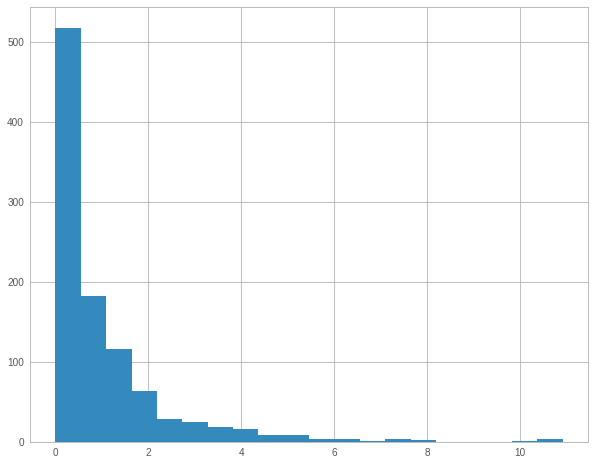

In [121]:
plots(samples_mh_g,s.lambda_(), None,1000)

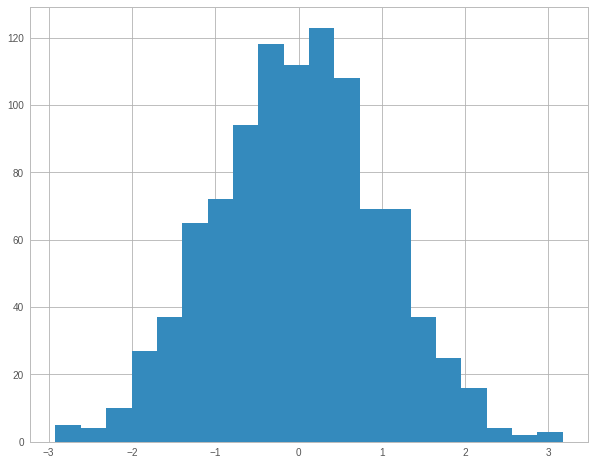

In [122]:
plots(samples_mh_g,s.beta(), None,1000)

In [123]:
dict_y = {s.y(): TRAIN_DATA_Y}
step_size = 0.5
num_steps=1

s = Sparse(D,TRAIN_DATA_X,TEST_DATA_X,TEST_DATA_Y)
hmc = bm.SingleSiteHamiltonianMonteCarlo(step_size, num_steps)
samples_hmc_g = hmc.infer([s.tau(),s.lambda_(),s.beta(),s.log_prob_test()], dict_y , 1000, 3,verbose=VerboseLevel.OFF)

In [124]:
analysis("single-site HMC on german data",samples_hmc_g, s.tau(),s.lambda_(),s.beta(),D,None,None,None)

for single-site HMC on german data:
        Predicted value
Tao            0.002756
Lambda         0.068305
Beta          -0.006263
for single-site HMC on german data:
        effective_sample_size     r_hat
Tao                277.754364  1.006382
Lambda              63.477085  1.068470
Beta               544.050659  1.003183


In [125]:
post_hmc_g = tensor(samples_hmc_g[s.log_prob_test()])
p_hmc_g=post_hmc_g.cumsum(dim=0) / arange(1, len(post_hmc_g[0])+1)

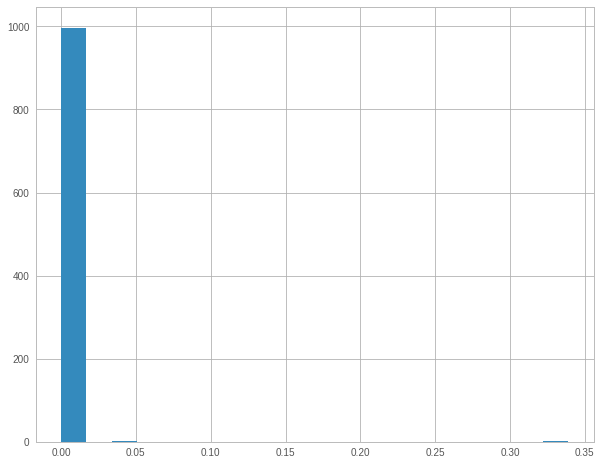

In [126]:
plots(samples_hmc_g,s.lambda_(), None,1000)

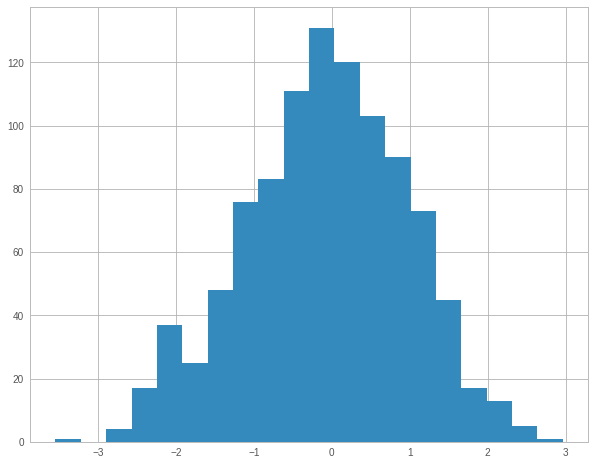

In [127]:
plots(samples_hmc_g,s.beta(), None,1000)

In [135]:
p_nw_g = post_nw_g.cumsum(dim=1)/ arange(1, len(post_mh[0])+1)
p_mh_g = post_mh_g.cumsum(dim=1)/ arange(1, len(post_mh[0])+1)
p_hmc_g = post_hmc_g.cumsum(dim=1)/ arange(1, len(post_mh[0])+1)
p_nw_g.size()

torch.Size([3, 1000])

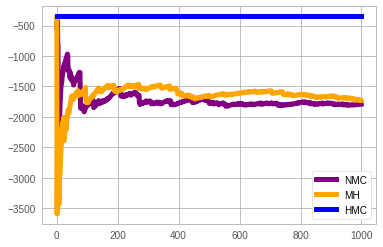

In [138]:
plt.plot(p_nw_g[-1],color="purple",linewidth=5,label='NMC')
plt.plot(p_mh_g[-1],color="orange",linewidth=5,label='MH')
plt.plot(p_hmc_g[-1],color="blue",linewidth=5,label='HMC')
plt.legend(framealpha=1, frameon=True)

In [143]:
analysis_log(p_nw_g,p_mh_g,p_hmc_g,None,1000)

     Predicted value
NMC     -1725.588702
MH      -1641.021490
HMC      -346.573591
